In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 작업환경 구성하기

$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/generated_samples
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_checkpoints
$ mkdir -p ~/aiffel/dcgan_newimage/cifar10/training_history

# 2. 데이터셋 구성하기 
- 학습에 사용할 train_x의 이미지를 -1, 1로 정규화합니다.
- 로드한 학습 데이터를 시각화를 통해 확인해 봅시다.
- tf.data.Dataset 모듈의 from_tensor_slices() 함수를 사용하여 미니배치 데이터셋을 구성해 봅시다

In [2]:
# tf.keras 안에 있는 datasets

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

### 데이터셋 정규화

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

### 학습 데이터 시각화로 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

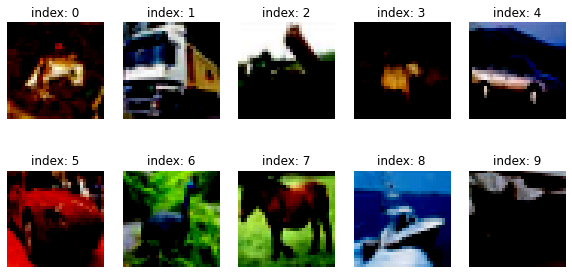

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

### 미니배치 데이터셋 구성

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 3. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다.

### 생성자 모델 구현 함수

In [25]:
def make_generator_model():
    model = tf.keras.Sequential()

    # First: Dense layer → (4, 4, 512)
    # 목표 이미지 크기가 작아졌으므로 초기 Dense 레이어의 출력 크기를 조정합니다.
    model.add(layers.Dense(4 * 4 * 512, use_bias=False, input_dim=100))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Reshape → (4, 4, 512)
    model.add(layers.Reshape((4, 4, 512)))

    # Third: Upsample → (4x4 → 8x8)
    model.add(layers.Conv2DTranspose(256, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fourth: Upsample → (8x8 → 16x16)
    model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Upsample → (16x16 → 32x32)
    model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Sixth: Final Conv2DTranspose layer → (32x32x3)
    model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding='same', use_bias=False, activation='tanh'))

    return model


함수 잘 만들어졌는지 확인

In [27]:
generator = make_generator_model()

In [28]:
generator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_19 (Batc (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_19 (Conv2DT (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 8, 8, 256)        

### 노이즈 벡터 만들어 랜덤 이미지 생성

In [29]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

### 랜덤 이미지 잘 만들어졌는지 확인

In [30]:
generated_image.shape

TensorShape([1, 32, 32, 3])

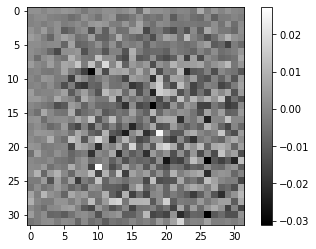

In [31]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

# 4. 판별자 모델 구현하기

- (32, 32, 3)의 이미지를 입력으로 받아 1dim을 판별결과를 출력하는 판별자 모델 구현 함수를 작성해 봅시다. 
- 위 STEP 2에서 생성한 랜덤 이미지를 판별자 모델이 판별한 결과값을 확인해 봅시다.

### 판별자 모델 구현 함수

In [32]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # 1. Conv2D Layer
    model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding='same', input_shape=(32, 32, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 2. Conv2D Layer
    model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # 3. Flatten
    model.add(layers.Flatten())

    # 4. Dense Layer (Real/Fake 판별)
    model.add(layers.Dense(1))

    return model

In [33]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

### 판별 결과 확인해보기

In [34]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00037194]], dtype=float32)>

# 5. 손실함수와 최적화 함수 구현하기
- 생성자와 판별자의 손실함수(loss)를 구현해 봅시다.
- 판별자의 출력값을 가지고 실제/생성(real/fake) 이미지 판별 정확도(accuracy)를 계산하는 함수를 구현해 봅시다.
- 생성자와 판별자를 최적화하는 optimizer를 정의합니다.

### generator loss 구현

In [35]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator loss 구현

In [36]:
def discriminator_loss(real_output, fake_output):
    # 손실함수는 cross entropy를 사용, ones_like를 활용
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 손실함수는 cross entropy를 사용, zeros_like를 활용
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    # real_loss와 fake_loss를 더한 값
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuracy 구현

In [37]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### optimizer 정의

In [38]:
#optimizer 만들기
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

#noise_dim, 샘플생성개수 설정
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 6. 훈련과정 상세 기능 구현하기
- 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.
- 16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.
- 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
- training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

### train_setp 함수 구현

In [41]:
import tensorflow as tf

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # (1) 생성자 입력으로 사용할 노이즈 벡터

    # GradientTape로 생성자와 판별자에 대한 그래디언트를 계산합니다.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # (3) GradientTape 오픈
        generated_images = generator(noise, training=True)  # (4) 생성자 출력 이미지를 생성

        # 판별자가 실제 이미지와 가짜 이미지를 판별합니다.
        real_output = discriminator(images, training=True)  # (5) 실제 이미지에 대한 판별자 출력
        fake_output = discriminator(generated_images, training=True)  # (5) 생성된 이미지에 대한 판별자 출력

        # 생성자 손실 계산 (가짜 이미지에 대해 판별자가 0에 가까운 값을 내도록 학습)
        gen_loss = generator_loss(fake_output)
        # 판별자 손실 계산 (실제 이미지에 대해 1에 가까운 값을 내고, 가짜 이미지에 대해 0에 가까운 값을 내도록 학습)
        disc_loss = discriminator_loss(real_output, fake_output)

        # 정확도 계산 (real_output이 1에 가까운지, fake_output이 0에 가까운지)
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)

    # 생성자와 판별자에 대한 그래디언트를 계산합니다.
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)  # (8) 생성자 그래디언트 계산
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)  # (8) 판별자 그래디언트 계산

    # 생성자와 판별자의 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))  # (9) 생성자 학습
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))  # (9) 판별자 학습

    # 손실 값과 정확도를 반환합니다.
    return gen_loss, disc_loss, real_accuracy, fake_accuracy  # (10) 리턴값


### generate_and_save_images 함수 구현

In [42]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))
# plt에 저장되어 보이는 이미지를 파일로 저
    plt.show()

### draw_train_history 함수 구현

In [43]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### checkpoint_dir

In [44]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 7. 학습 과정 진행하기
- 위 STEP 5에서 구현한 기능들을 활용하여 최소 50 epoch만큼의 모델 학습을 진행해 봅시다.
- 학습 과정에서 생성된 샘플 이미지로 만든 gif 파일을 통해 학습 진행 과정을 시각적으로 표현해 봅시다.
- 학습 과정을 담은 샘플 이미지, gif 파일, 학습 진행 그래프 이미지를 함께 제출합니다

### 모델 학습

In [45]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [46]:
save_every = 5
EPOCHS = 50

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

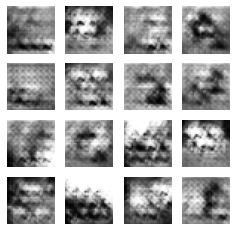

Time for training : 1810 sec


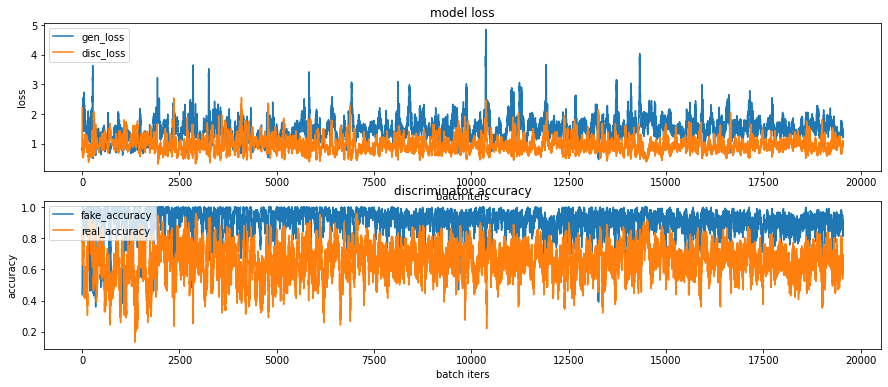

CPU times: user 30min 52s, sys: 1min 55s, total: 32min 47s
Wall time: 30min 11s


In [48]:
%%time
train(train_dataset, epochs=50, save_every=10)

### 학습과정 시각화하기

In [56]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1769728 Apr 17 03:20 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif


# 8. GAN훈련과정 개선하기 
- STEP 6을 진행하면서 생성된 샘플 이미지, 학습 과정 그래프 등을 통해 이전 훈련 과정의 문제점을 분석해 봅시다.
- 모델구조 또는 학습 과정을 개선한 내역과 그 결과(샘플 이미지, 학습 과정 그래프 포함)를 함께 제출합니다.